In [2]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
import json
import numpy as np
from tqdm import tqdm


class IDD20KLLDataset(Dataset):
    def __init__(self, image_root, mask_root, transforms=None):
        self.image_paths = []
        self.mask_paths = []
        self.transforms = transforms

        # Collect all image and mask paths
        for subdir, _, files in tqdm(os.walk(mask_root)):  # Iterate through mask_root
            for file in files:
                if file.endswith("_gtFine_polygons.json"):  # JSON files
                    # Extract the base filename (e.g., "frame0029")
                    base_name = file.replace("_gtFine_polygons.json", "")
                    # Construct paths
                    mask_path = Path(subdir) / file
                    image_path = Path(image_root) / Path(subdir).relative_to(mask_root) / f"{base_name}_leftImg8bit.jpg"

                    # Check if corresponding image exists
                    if image_path.exists():
                        self.mask_paths.append(mask_path)
                        self.image_paths.append(image_path)
                    else:
                        print(f"Warning: Image not found for mask: {mask_path}")

        print(f"Found {len(self.image_paths)} images")
        print(f"Found {len(self.mask_paths)} masks")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask_path = self.mask_paths[idx]

        # Generate class mask from JSON
        mask = self.create_class_mask(mask_path, image.size)

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)
            mask = transforms.Resize((512, 512))(mask)  # Resize mask to (512, 512)
            mask = np.array(mask, dtype=np.uint8)  # Ensure it is integer class indices
            mask = torch.tensor(mask, dtype=torch.long)  # Convert to tensor after transformations

        return image, mask  # Return (image, mask)

    @staticmethod
    def create_class_mask(json_path, image_size):
        with open(json_path, 'r') as f:
            data = json.load(f)

        img_width, img_height = image_size
        mask = np.zeros((img_height, img_width), dtype=np.uint8)  # Single-channel binary mask

        # Draw polygons for all labels
        for obj in data["objects"]:
            if not obj["deleted"]:
                polygon = [(point[0], point[1]) for point in obj["polygon"]]
                # Skip polygons with fewer than 2 points
                if len(polygon) < 2:
                    print(f"Warning: Skipping invalid polygon with {len(polygon)} points in {json_path}")
                    continue
                img = Image.new("L", (img_width, img_height), 0)  # "L" mode creates a single-channel grayscale image
                ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
                mask += np.array(img, dtype=np.uint8)

        return Image.fromarray(mask)  # Return as a PIL Image


In [3]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
# Define Paths
mask_root = "E:\\Projects\\Finished\\Semantic Segmentation\\idd20kII\\gtFine"
image_root = "E:\\Projects\\Finished\\Semantic Segmentation\\idd20kII\\leftImg8bit"
train_image_root = os.path.join(image_root, "train")
train_mask_root = os.path.join(mask_root, "train")

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images and masks
    transforms.ToTensor(),          # Convert to Tensor
])

# Create Dataset Instance
train_dataset = IDD20KLLDataset(train_image_root, train_mask_root, transforms=transform)
# def count_classes(dataset):
#     unique_classes = set()
#     for _, mask in tqdm(dataset):  # Iterate over all (image, mask) pairs
#         unique_classes.update(torch.unique(mask).tolist())  # Add unique values in the mask
#     return len(unique_classes), unique_classes

# # Count unique classes in the dataset
# num_classes, unique_classes = count_classes(train_dataset)
# print(f"Number of classes: {num_classes}")
# print(f"Unique class labels: {unique_classes}")


250it [00:12, 20.51it/s]

Found 7034 images
Found 7034 masks


In [8]:
# Define the U-Net model with a ResNet34 encoder
num_classes = 13
model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",    # Pretrained on ImageNet
    in_channels=3,                 # Input channels (RGB)
    classes=num_classes                     # Output channels (binary or number of classes)
)

In [9]:
# # Define the U-Net model with a ResNet34 encoder
# num_classes = 13
# model = smp.Unet(
#     encoder_name="resnet34",        # Encoder backbone
#     encoder_weights="imagenet",    # Pretrained on ImageNet
#     in_channels=3,                 # Input channels (RGB)
#     classes=num_classes                     # Output channels (binary or number of classes)
# )
# # Loss Function: Use CrossEntropyLoss for multi-class or DiceLoss for segmentation
# loss_fn = smp.losses.DiceLoss(mode='multiclass')  # Or use nn.CrossEntropyLoss()

# # Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# # Define DataLoader
# batch_size = 8
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# num_epochs = 10

# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     model.train()
#     train_loss = 0

#     for images, masks in tqdm(train_loader):

#         images = images.to(device)
#         masks = masks.to(device)

#         # Forward pass
#         outputs = model(images)

#         loss = loss_fn(outputs, masks)
#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     avg_loss = train_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# # Save the trained model
# torch.save(model.state_dict(), "unet_segmentation_model.pth")


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("C:\\Users\\Ahmad\\OneDrive\\Desktop\\Labs\\CV\\Project\\Models\\unet-finetuned\\unet_segmentation_model.pth", map_location=device))

# Initialize model and load weights
#model.to(device)

print("Model loaded successfully.")

# Define loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=13)


# Define evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images#.to(device)
            masks = masks#.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(val_loader)


val_image_root = os.path.join(image_root, "val")
val_mask_root = os.path.join(mask_root, "val")

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images and masks
    transforms.ToTensor(),          # Convert to Tensor
])

# Create Dataset Instance
batch_size = 8  # Adjust batch size as needed
val_dataset = IDD20KLLDataset(val_image_root, val_mask_root, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
label_nums = []

# Evaluate model
val_loss = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")


Model loaded successfully.


51it [00:00, 587.10it/s]


Found 1055 images
Found 1055 masks


 10%|▉         | 13/132 [02:11<21:06, 10.64s/it]

 45%|████▍     | 59/132 [09:51<12:59, 10.67s/it]

100%|██████████| 132/132 [20:08<00:00,  9.16s/it]

Validation Loss: 3.0369


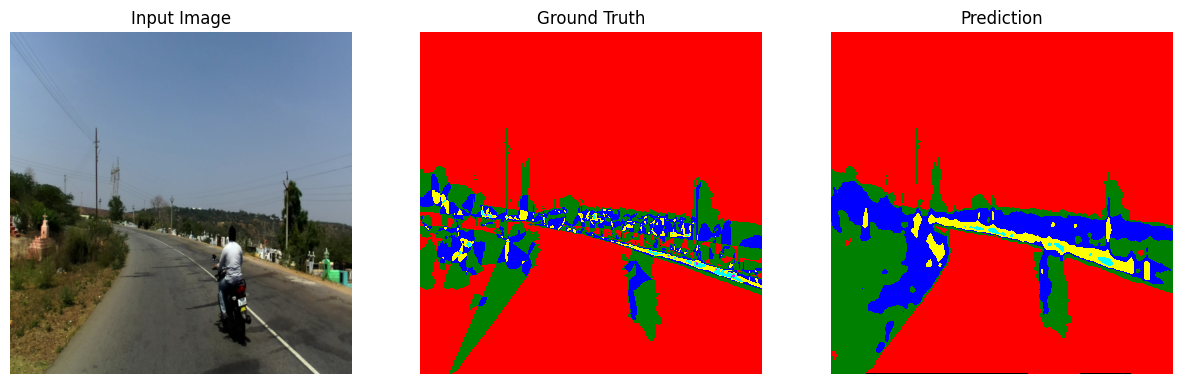

In [20]:
import matplotlib.colors as mcolors

# Visualization Function
def visualize_predictions(model, dataset, idx):
    model.eval()
    model.to(device)
    image, mask = dataset[idx]
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image)
        pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()

    # Convert tensors to numpy
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mask = mask.cpu().numpy()

    # Define a colormap for visualization
    cmap = mcolors.ListedColormap([
        "black", "red", "green", "blue", "yellow", "cyan", "magenta", 
        "orange", "purple", "brown", "pink", "lime", "gray"
    ])
    # Define a normalization for the colormap
    norm = mcolors.BoundaryNorm(boundaries=np.arange(14) - 0.5, ncolors=14)

    plt.figure(figsize=(15, 5))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask, cmap=cmap, norm=norm)
    #plt.colorbar(ticks=np.arange(13), label="Class")  # Adjust number of classes as needed
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred_mask, cmap=cmap, norm=norm)
    #plt.colorbar(ticks=np.arange(13), label="Class")
    plt.axis("off")

    plt.show()

# Visualize a random prediction
idx = 0  # Choose an index from the validation dataset
visualize_predictions(model, val_dataset, idx=idx)
